In [1]:
%matplotlib inline
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn

sn.set_theme()

tweetsDatasetPath = "../dataset/tweets_clean_with_outliers.h5"
usersDatasetPath = "../dataset/users_clean_with_outliers.h5"

resultTweetsDatasetPath = "../dataset/tweets_no_outliers.h5"
resultUsersDatasetPath = "../dataset/users_no_outliers.h5"

In [2]:
# compute the interquartile range and set the median to df.attr of the outliers 
def compute_outliers(df, attr, higherQuantile = 0.75):
    Q1 = df[attr].quantile(0.25)
    Q2 = df[attr].quantile(0.50)
    Q3 = df[attr].quantile(higherQuantile)
    #Q1 = df[attr].quantile(0.25)
    #Q3 = df[attr].quantile(higherQuantile)
    #IQR = Q3 - Q1    #IQR is interquartile range
    #print("Q1:", Q1, "Q3:", Q3, "IQR:", IQR)
    SIQR_high = Q3 - Q2
    SIQR_low = Q2 - Q1
    upperLimit = Q3 + 3 * SIQR_high
    lowerLimit = Q1 - 3 * SIQR_low
    print("Q1:", Q1, "Q2:", Q2, "Q3:", Q3, "SIQR_high:", SIQR_high, "SIQR_low:", SIQR_low, "lowerLimit:", lowerLimit, "upperLimit:", upperLimit)
    
    #filter = (df[attr] >= Q1 - 1.5 * IQR) & (df[attr] <= Q3 + 1.5 * IQR)
    #valid = df.loc[filter]
    #filter = (df[attr] < Q1 - 1.5 * IQR) | (df[attr] > Q3 + 1.5 * IQR)
    filter = (df[attr] < lowerLimit) | (df[attr] > upperLimit)
    outliers = df.loc[filter]
    
    print("We have", len(outliers), "outliers over", len(df), "entries (", (len(outliers) / len(df)) * 100, "%)")
    
    return outliers

In [3]:
def display_plots(df, column, higherQuantile = 0.75):
    numberOfBins = int(np.log2(df[column].count()) + 1)
    print("Number of bins:", numberOfBins)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    #df.boxplot(column=column, ax=ax1)
    # Plot boxplot setting the whiskers
    sn.boxplot(df[column], ax = ax1, width=0.3, whis = [25, higherQuantile * 100])
    #df.hist(column=column, ax=ax2, stacked=True, bins=numberOfBins)
    ax2.set_yscale('log')
    sn.histplot(data=df[column], bins=numberOfBins)
    #fig.subplots_adjust(wspace=0.3)
    plt.title(column)
    plt.show()

def log_scale(df, column):
    return pd.DataFrame(np.log10(1+df[column][df[column].notna()]))

def analyze_outliers(df, column, higherQuantile = 0.75):
    display_plots(df, column, higherQuantile = higherQuantile)

    # compute outliers
    outliers = compute_outliers(df, column, higherQuantile = higherQuantile)
    minOutlierValue = df.loc[outliers.index][column].min()
    maxOutlierValue = df.loc[outliers.index][column].max()
    print("Min outlier:", minOutlierValue, "   Max outlier:", maxOutlierValue)

    print("\n\nLog scale")
    column_log_scale = log_scale(df, column)
    display_plots(column_log_scale, column, higherQuantile = higherQuantile)

    # compute outliers from log scale
    log_outliers = compute_outliers(column_log_scale, column, higherQuantile = higherQuantile)
    minOutlierValue = df.loc[log_outliers.index][column].min()
    maxOutlierValue = df.loc[log_outliers.index][column].max()
    print("Min outlier:", minOutlierValue, "   Max outlier:", maxOutlierValue)

    return outliers

def tweets_fill_outliers(df, column, outliers):
    outliers = compute_outliers(df, column)
    df.loc[outliers.index, column] = np.nan
    df[column].fillna(df.groupby(["user_id"])[column].transform(lambda x: np.floor(np.nanmedian(x))), inplace=True)
    df.loc[df[column].isna(), column] = np.floor(np.nanmedian(df[column]))

# Tweets dataset

In [4]:
%%time
df_tweets = pd.read_hdf(tweetsDatasetPath)

CPU times: total: 13.7 s
Wall time: 15.9 s


In [5]:
df_tweets.dtypes

user_id                  float64
retweet_count              int64
reply_count                int64
favorite_count             int64
num_hashtags               int64
num_urls                   int64
num_mentions               int64
created_at        datetime64[ns]
text                      object
dtype: object

Number of bins: 24


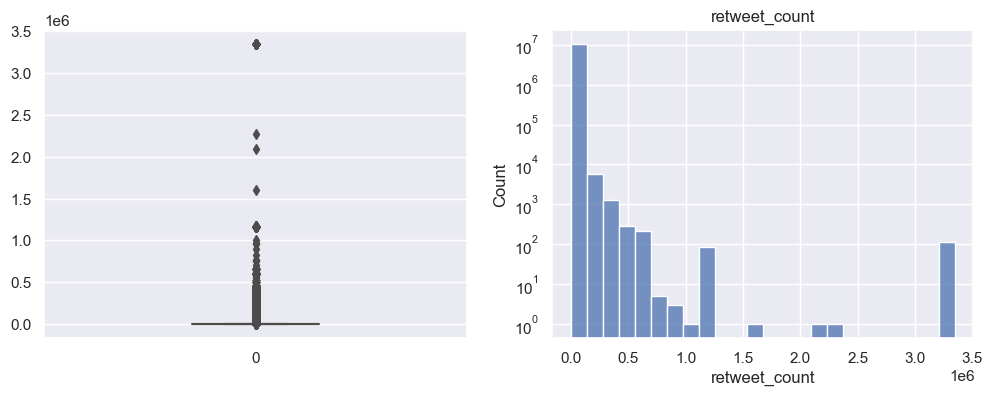

Q1: 0.0 Q2: 0.0 Q3: 1.0 SIQR_high: 1.0 SIQR_low: 0.0 lowerLimit: 0.0 upperLimit: 4.0
We have 1438212 outliers over 10463160 entries ( 13.745484155838197 %)
Min outlier: 5    Max outlier: 3350111


Log scale
Number of bins: 24


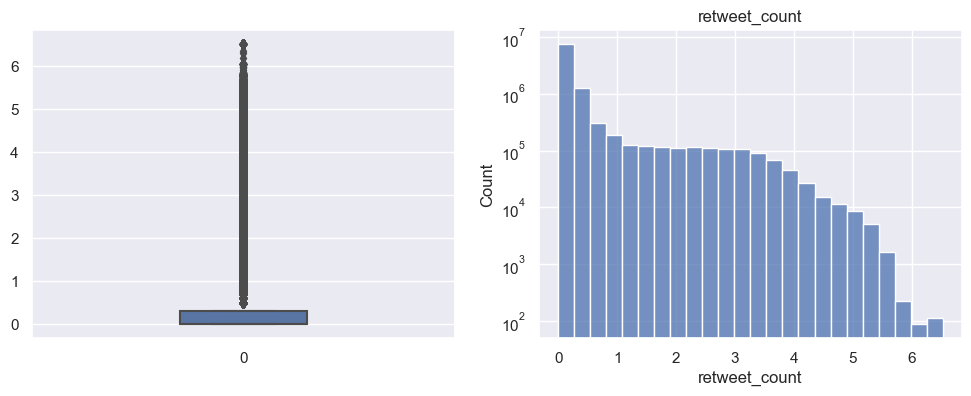

Q1: 0.0 Q2: 0.0 Q3: 0.3010299956639812 SIQR_high: 0.3010299956639812 SIQR_low: 0.0 lowerLimit: 0.0 upperLimit: 1.2041199826559248
We have 1128838 outliers over 10463160 entries ( 10.788690988190949 %)
Min outlier: 16    Max outlier: 3350111


In [6]:
retweet_count_outliers = analyze_outliers(df_tweets, "retweet_count", higherQuantile = 0.75)

Number of bins: 24


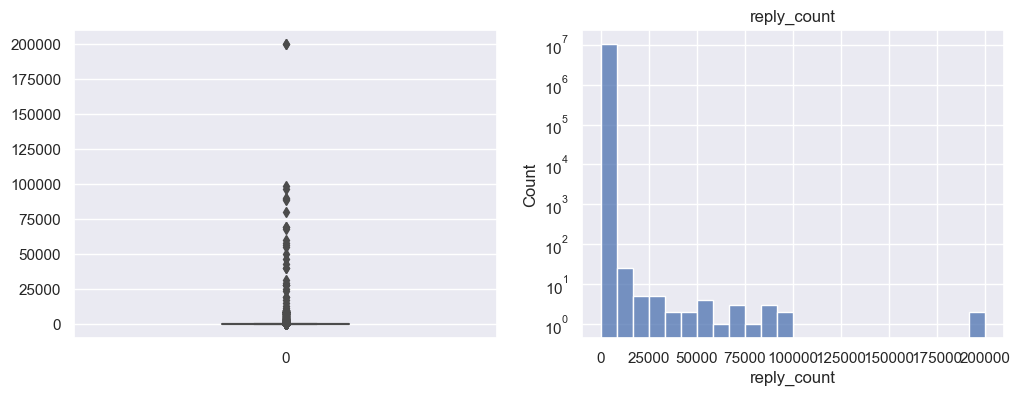

Q1: 0.0 Q2: 0.0 Q3: 0.0 SIQR_high: 0.0 SIQR_low: 0.0 lowerLimit: 0.0 upperLimit: 0.0
We have 17848 outliers over 10463160 entries ( 0.17057944253934756 %)
Min outlier: 1    Max outlier: 200000


Log scale
Number of bins: 24


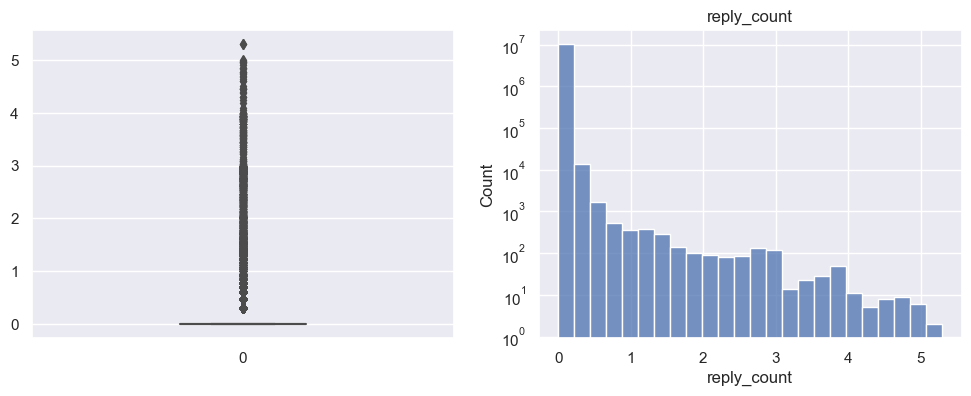

Q1: 0.0 Q2: 0.0 Q3: 0.0 SIQR_high: 0.0 SIQR_low: 0.0 lowerLimit: 0.0 upperLimit: 0.0
We have 17848 outliers over 10463160 entries ( 0.17057944253934756 %)
Min outlier: 1    Max outlier: 200000


In [7]:
retweet_count_outliers = analyze_outliers(df_tweets, "reply_count", higherQuantile = 0.75)

Number of bins: 24


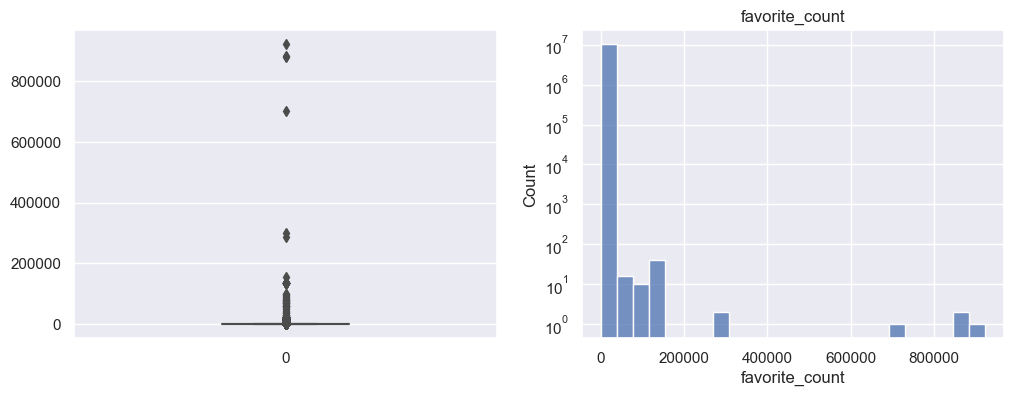

Q1: 0.0 Q2: 0.0 Q3: 0.0 SIQR_high: 0.0 SIQR_low: 0.0 lowerLimit: 0.0 upperLimit: 0.0
We have 2068793 outliers over 10463160 entries ( 19.772162520691648 %)
Min outlier: 1    Max outlier: 922462


Log scale
Number of bins: 24


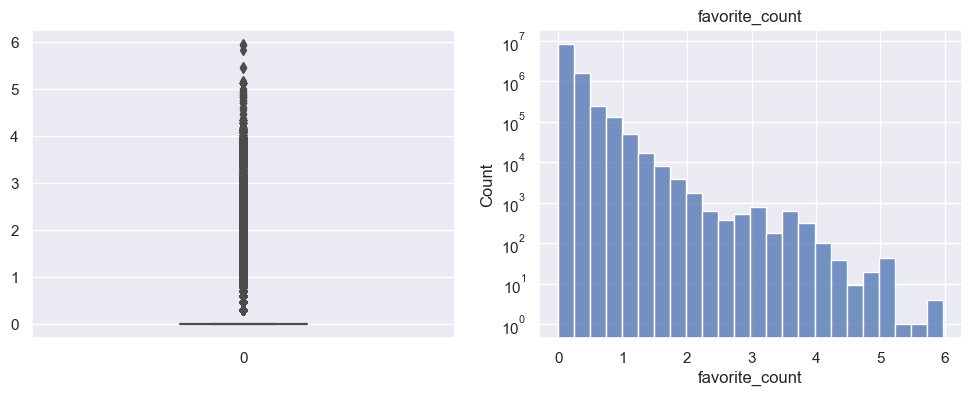

Q1: 0.0 Q2: 0.0 Q3: 0.0 SIQR_high: 0.0 SIQR_low: 0.0 lowerLimit: 0.0 upperLimit: 0.0
We have 2068793 outliers over 10463160 entries ( 19.772162520691648 %)
Min outlier: 1    Max outlier: 922462


In [8]:
retweet_count_outliers = analyze_outliers(df_tweets, "favorite_count", higherQuantile = 0.75)

Number of bins: 24


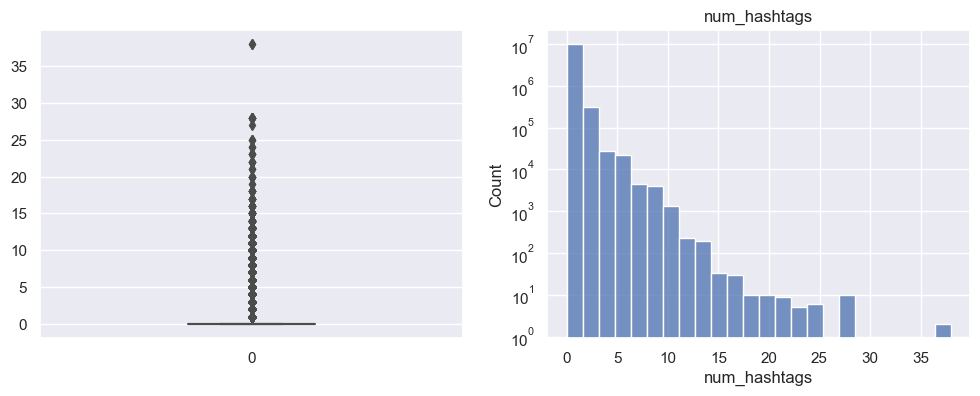

Q1: 0.0 Q2: 0.0 Q3: 0.0 SIQR_high: 0.0 SIQR_low: 0.0 lowerLimit: 0.0 upperLimit: 0.0
We have 1170072 outliers over 10463160 entries ( 11.182778434048604 %)
Min outlier: 1    Max outlier: 38


Log scale
Number of bins: 24


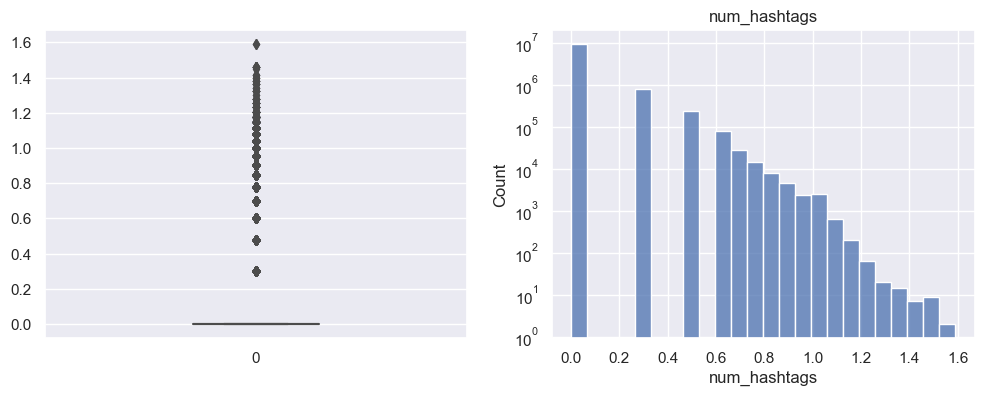

Q1: 0.0 Q2: 0.0 Q3: 0.0 SIQR_high: 0.0 SIQR_low: 0.0 lowerLimit: 0.0 upperLimit: 0.0
We have 1170072 outliers over 10463160 entries ( 11.182778434048604 %)
Min outlier: 1    Max outlier: 38


In [9]:
retweet_count_outliers = analyze_outliers(df_tweets, "num_hashtags", higherQuantile = 0.75)

Number of bins: 24


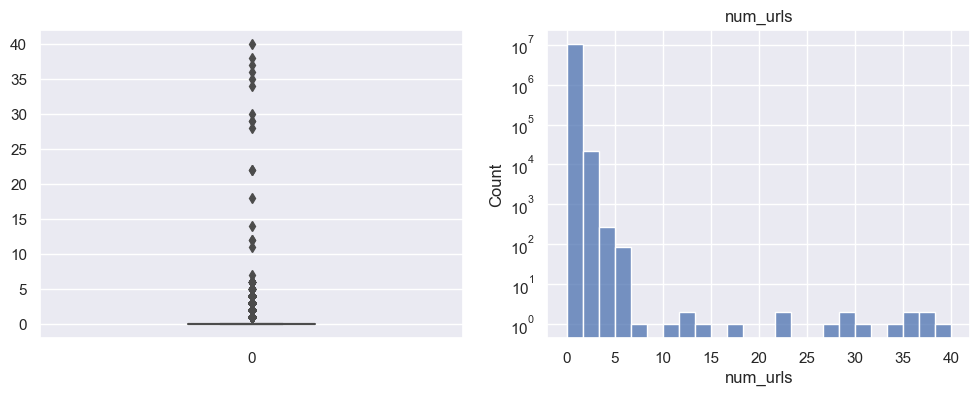

Q1: 0.0 Q2: 0.0 Q3: 0.0 SIQR_high: 0.0 SIQR_low: 0.0 lowerLimit: 0.0 upperLimit: 0.0
We have 1667402 outliers over 10463160 entries ( 15.935931401221046 %)
Min outlier: 1    Max outlier: 40


Log scale
Number of bins: 24


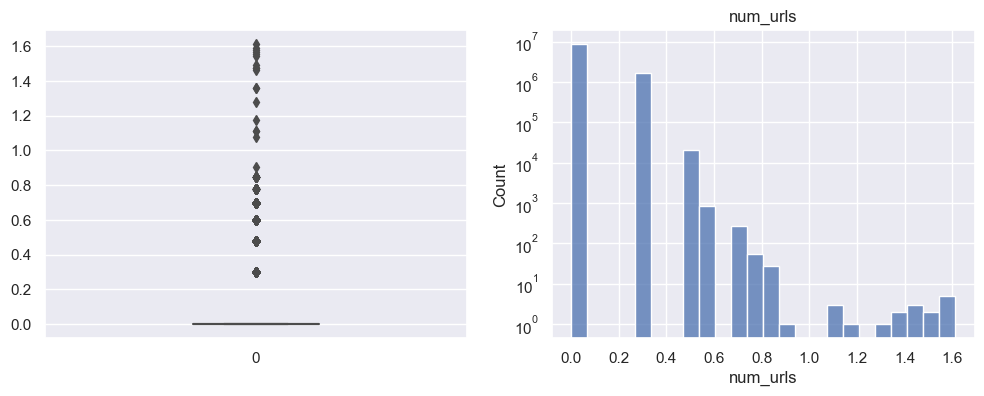

Q1: 0.0 Q2: 0.0 Q3: 0.0 SIQR_high: 0.0 SIQR_low: 0.0 lowerLimit: 0.0 upperLimit: 0.0
We have 1667402 outliers over 10463160 entries ( 15.935931401221046 %)
Min outlier: 1    Max outlier: 40


In [10]:
retweet_count_outliers = analyze_outliers(df_tweets, "num_urls", higherQuantile = 0.75)

Number of bins: 24


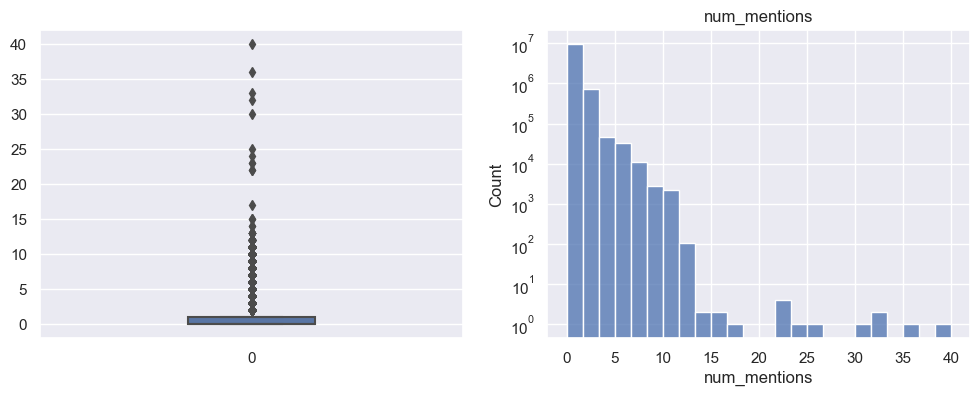

Q1: 0.0 Q2: 0.0 Q3: 1.0 SIQR_high: 1.0 SIQR_low: 0.0 lowerLimit: 0.0 upperLimit: 4.0
We have 48143 outliers over 10463160 entries ( 0.46011912271245015 %)
Min outlier: 5    Max outlier: 40


Log scale
Number of bins: 24


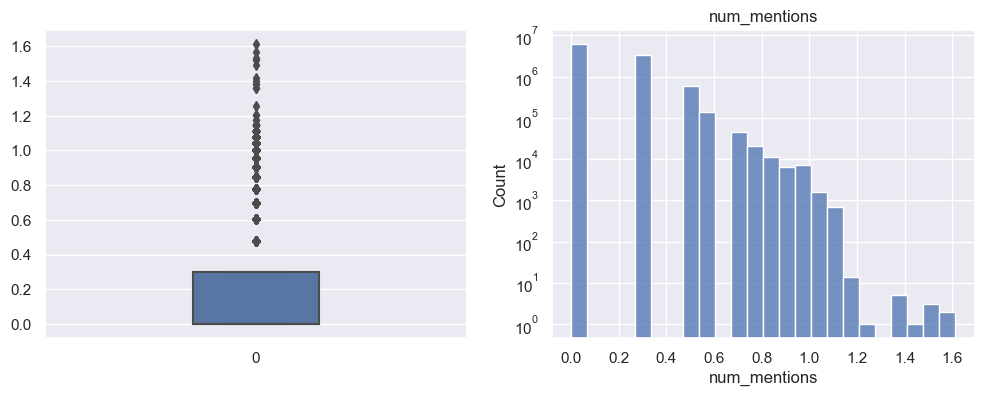

Q1: 0.0 Q2: 0.0 Q3: 0.3010299956639812 SIQR_high: 0.3010299956639812 SIQR_low: 0.0 lowerLimit: 0.0 upperLimit: 1.2041199826559248
We have 12 outliers over 10463160 entries ( 0.0001146881056965582 %)
Min outlier: 17    Max outlier: 40


In [11]:
retweet_count_outliers = analyze_outliers(df_tweets, "num_mentions", higherQuantile = 0.75)

### Remove outliers

In [12]:
df_tweets.describe()

,user_id,retweet_count,reply_count,favorite_count,num_hashtags,num_urls,num_mentions
count,1.046316e+07,1.046316e+07,1.046316e+07,1.046316e+07,1.046316e+07,1.046316e+07,1.046316e+07
mean,2.867203e+289,5.656091e+02,2.721887e-01,2.435945e+00,1.735007e-01,1.616615e-01,5.274461e-01
std,inf,1.397245e+04,1.303543e+02,6.199918e+02,6.151706e-01,3.764529e-01,8.110085e-01
min,-1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.127809e+08,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,4.671769e+08,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,1.175597e+09,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
max,3.000000e+296,3.350111e+06,2.000000e+05,9.224620e+05,3.800000e+01,4.000000e+01,4.000000e+01


In [13]:
medians = df_tweets.median()
medians

C:\Users\Domenico\AppData\Local\Temp\ipykernel_1580\2635813622.py:1: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  medians = df_tweets.median()
C:\Users\Domenico\AppData\Local\Temp\ipykernel_1580\2635813622.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  medians = df_tweets.median()


user_id           467176923.0
retweet_count             0.0
reply_count               0.0
favorite_count            0.0
num_hashtags              0.0
num_urls                  0.0
num_mentions              0.0
dtype: float64

In [14]:
""" tweets_fill_outliers(df_tweets, "retweet_count", retweet_count_outliers, medians)
tweets_fill_outliers(df_tweets, "reply_count", reply_count_outliers, medians)
tweets_fill_outliers(df_tweets, "favorite_count", favorite_count_outliers, medians)
tweets_fill_outliers(df_tweets, "num_hashtags", num_hashtags_outliers, medians)
tweets_fill_outliers(df_tweets, "num_urls", num_urls_outliers, medians)
tweets_fill_outliers(df_tweets, "num_mentions", num_mentions_outliers, medians) """

' tweets_fill_outliers(df_tweets, "retweet_count", retweet_count_outliers, medians)\ntweets_fill_outliers(df_tweets, "reply_count", reply_count_outliers, medians)\ntweets_fill_outliers(df_tweets, "favorite_count", favorite_count_outliers, medians)\ntweets_fill_outliers(df_tweets, "num_hashtags", num_hashtags_outliers, medians)\ntweets_fill_outliers(df_tweets, "num_urls", num_urls_outliers, medians)\ntweets_fill_outliers(df_tweets, "num_mentions", num_mentions_outliers, medians) '

In [15]:
df_tweets.describe()

,user_id,retweet_count,reply_count,favorite_count,num_hashtags,num_urls,num_mentions
count,1.046316e+07,1.046316e+07,1.046316e+07,1.046316e+07,1.046316e+07,1.046316e+07,1.046316e+07
mean,2.867203e+289,5.656091e+02,2.721887e-01,2.435945e+00,1.735007e-01,1.616615e-01,5.274461e-01
std,inf,1.397245e+04,1.303543e+02,6.199918e+02,6.151706e-01,3.764529e-01,8.110085e-01
min,-1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.127809e+08,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,4.671769e+08,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,1.175597e+09,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
max,3.000000e+296,3.350111e+06,2.000000e+05,9.224620e+05,3.800000e+01,4.000000e+01,4.000000e+01


### Correlation matrix after removing outliers

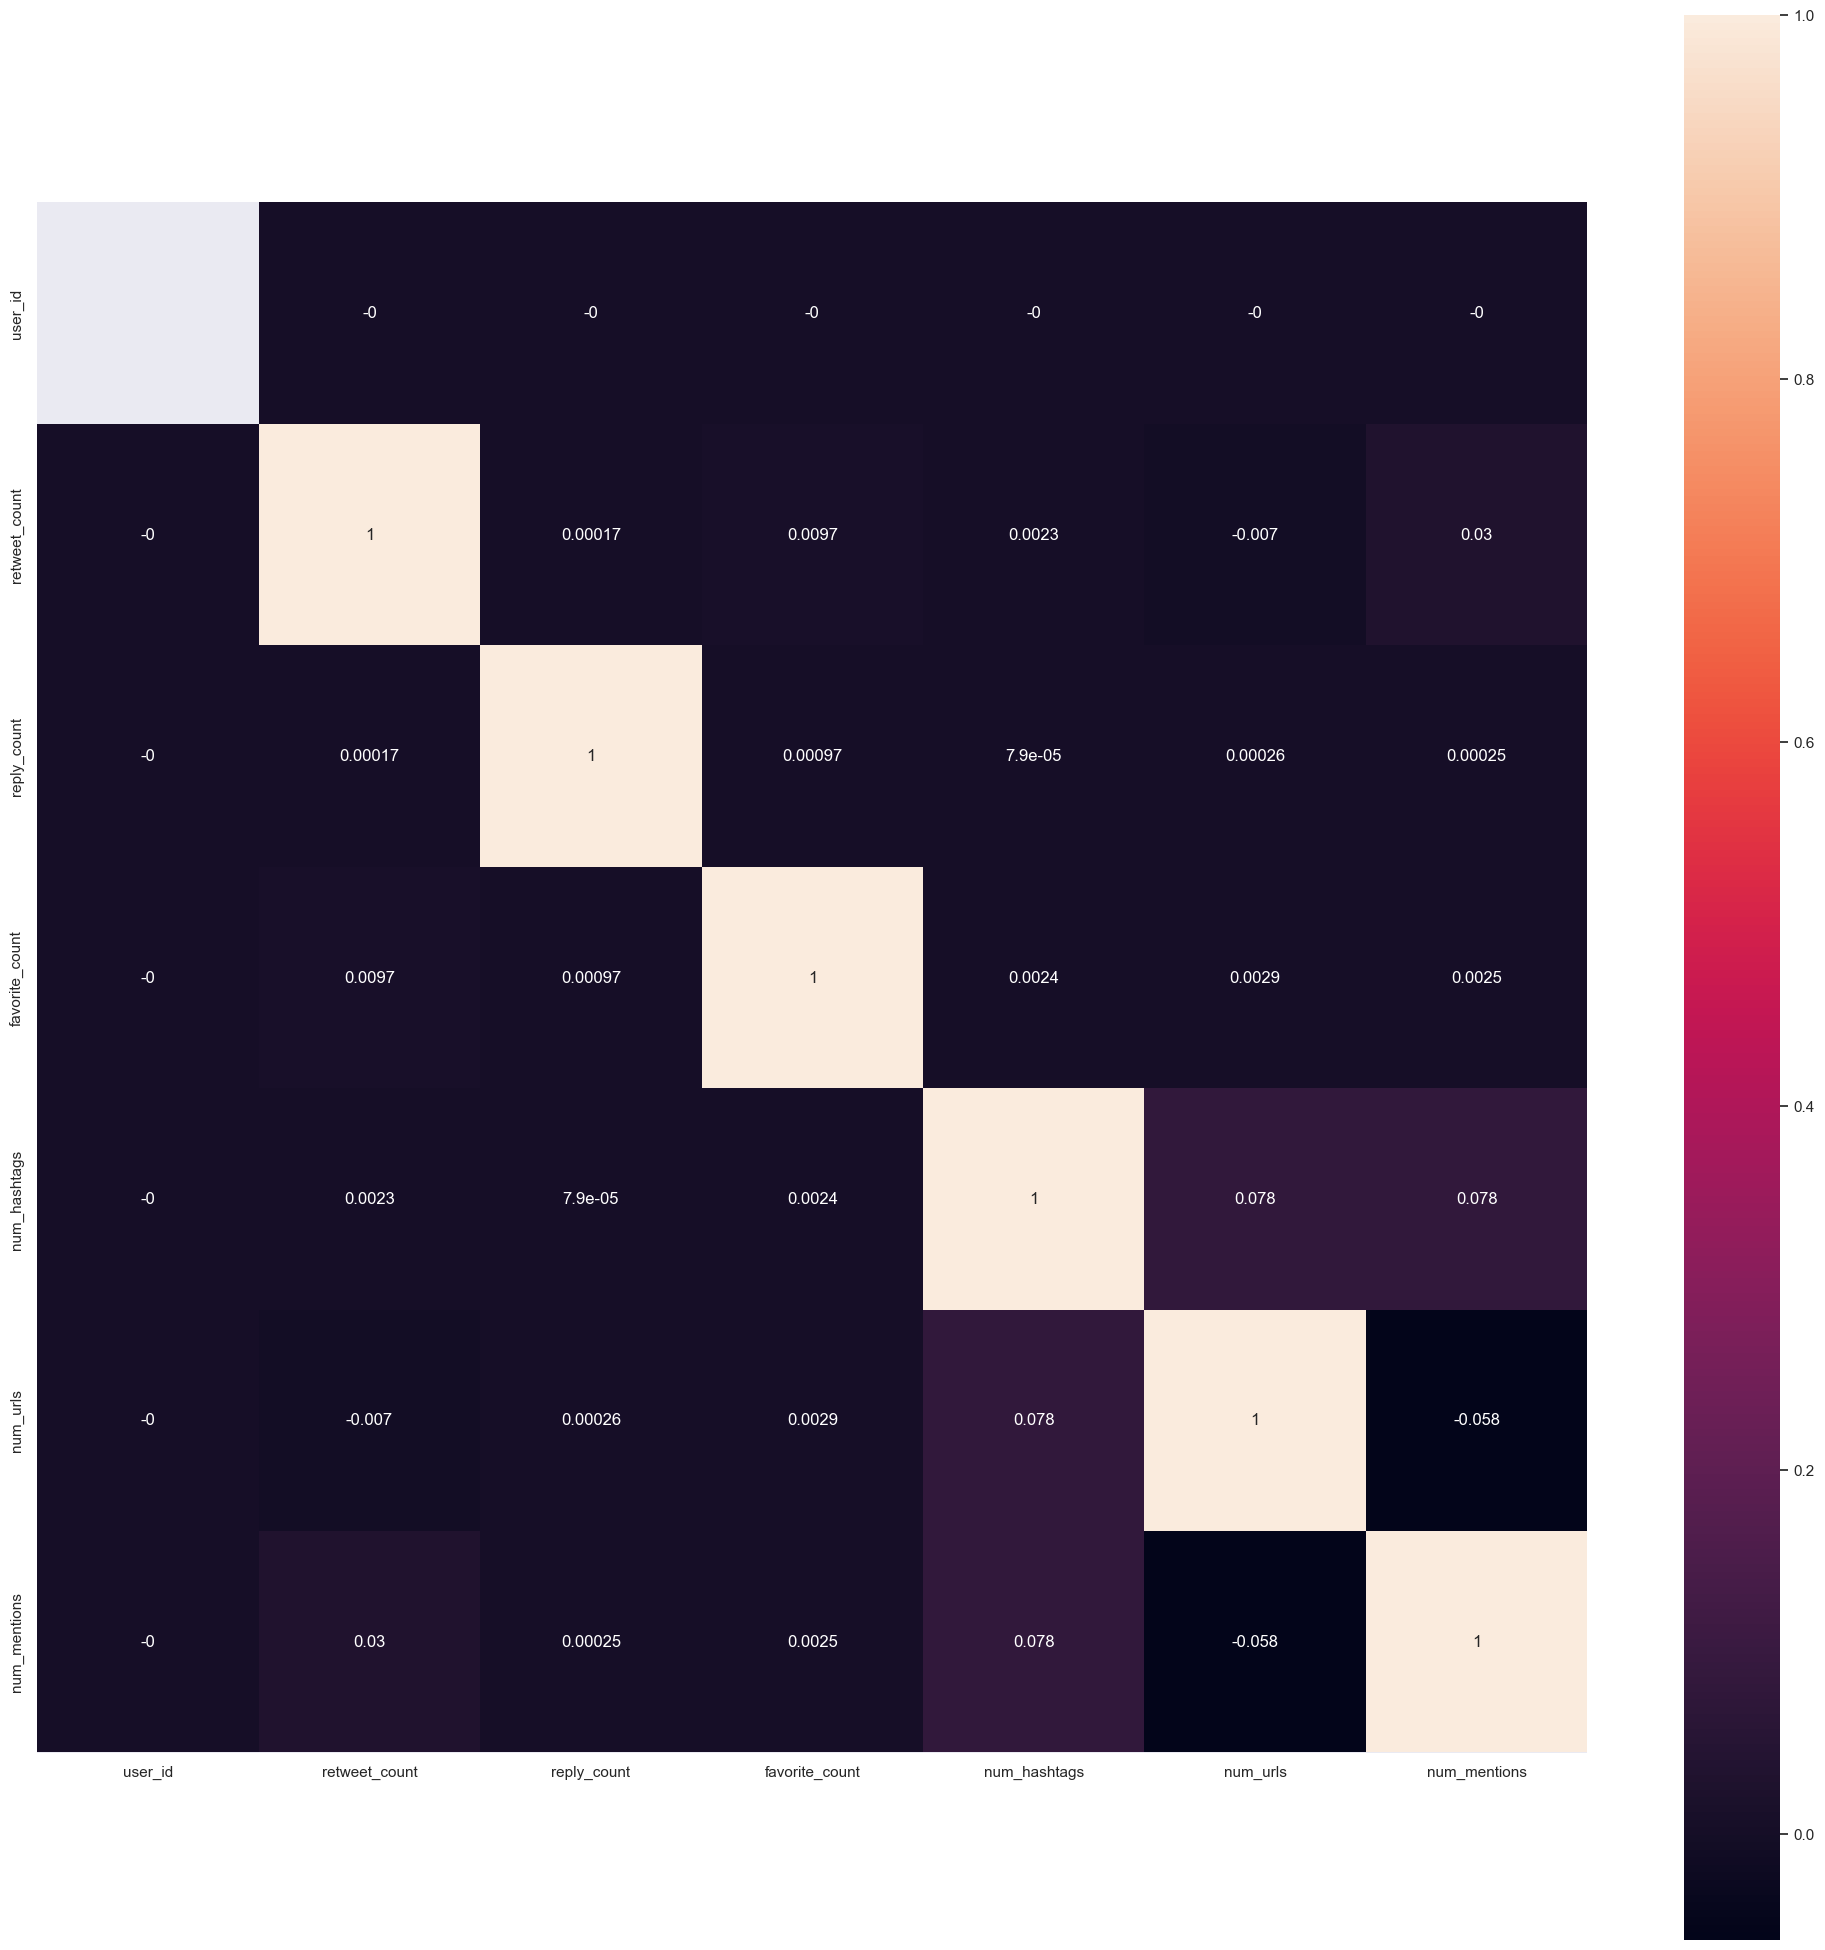

In [16]:
corr_matrix = df_tweets.corr()
fig, ax = plt.subplots(figsize=(25, 25))
mask = np.zeros_like(corr_matrix)
sn.heatmap(corr_matrix, annot=True, mask=mask, square=True)

plt.show()

### Save on file

In [17]:
df_tweets.to_hdf(resultTweetsDatasetPath, 'df_tweets', mode='w')

# Users dataset

In [18]:
%%time
df_users = pd.read_hdf(usersDatasetPath)

CPU times: total: 46.9 ms
Wall time: 49 ms


In [19]:
df_users.dtypes

name                      object
lang                      object
bot                        int64
created_at        datetime64[ns]
statuses_count             int64
dtype: object

In [20]:
df_users.describe()

,bot,statuses_count
count,11508.000000,11508.000000
mean,0.531456,5750.093500
std,0.499031,18752.596595
min,0.000000,0.000000
25%,0.000000,42.000000
50%,1.000000,71.000000
75%,1.000000,2520.250000
max,1.000000,399555.000000


In [21]:
def display_plots(df, column, higherQuantile = 0.75):
    numberOfBins = int(np.log2(df[column].count()) + 1)
    print("Number of bins:", numberOfBins)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    df.boxplot(column=column, ax=ax1)
    # Plot boxplot setting the whiskers
    #sn.boxplot(df[column], ax = ax1, width=0.3, whis = [25, higherQuantile * 100])
    df.hist(column=column, ax=ax2, stacked=True, bins=numberOfBins)
    ax2.set_yscale('log')
    #sn.histplot(data=df[column], bins=numberOfBins)
    #fig.subplots_adjust(wspace=0.3)
    plt.title(column)
    plt.show()

Number of bins: 14


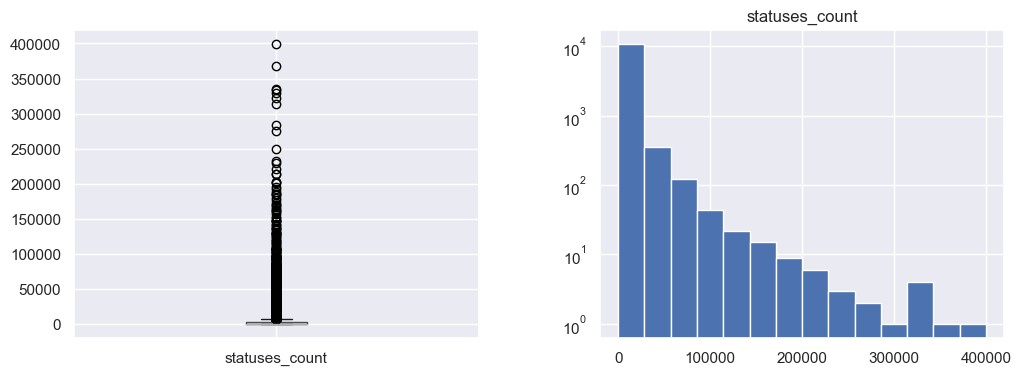

Q1: 42.0 Q2: 71.0 Q3: 2520.25 SIQR_high: 2449.25 SIQR_low: 29.0 lowerLimit: -45.0 upperLimit: 9868.0
We have 1765 outliers over 11508 entries ( 15.337156760514425 %)
Min outlier: 9878    Max outlier: 399555


Log scale
Number of bins: 14


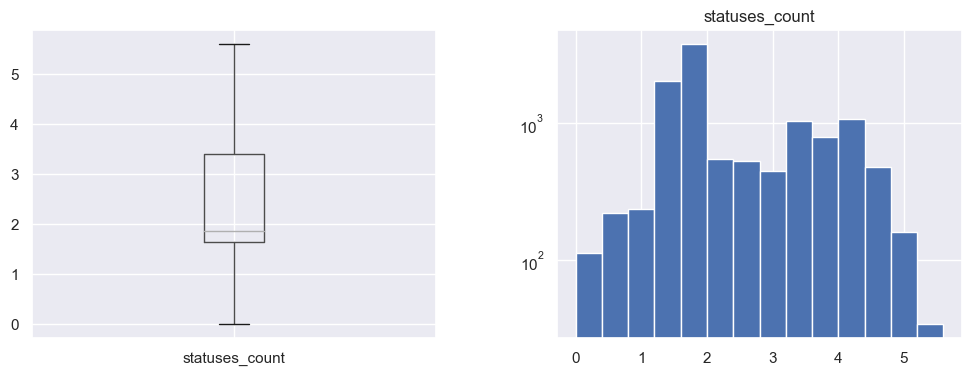

Q1: 1.6334684555795864 Q2: 1.8573324964312685 Q3: 3.4016159048166004 SIQR_high: 1.5442834083853318 SIQR_low: 0.2238640408516821 lowerLimit: 0.9618763330245401 upperLimit: 8.034466129972596
We have 396 outliers over 11508 entries ( 3.441084462982273 %)
Min outlier: 0    Max outlier: 8


In [22]:
statuses_count_outliers = analyze_outliers(df_users, "statuses_count", higherQuantile=0.75)

### Remove outliers

In [23]:
""" print("Median with outliers:")
print(df_users.groupby(["bot"])["statuses_count"].apply(lambda x: np.nanmedian(x)))
df_users.loc[statuses_count_outliers.index, "statuses_count"] = np.nan
df_users["statuses_count"].fillna(df_users["statuses_count"].transform(lambda x: np.nanmedian(x)), inplace=True)
print("Median:")
print(df_users.groupby(["bot"])["statuses_count"].apply(lambda x: np.nanmedian(x))) """

' print("Median with outliers:")\nprint(df_users.groupby(["bot"])["statuses_count"].apply(lambda x: np.nanmedian(x)))\ndf_users.loc[statuses_count_outliers.index, "statuses_count"] = np.nan\ndf_users["statuses_count"].fillna(df_users["statuses_count"].transform(lambda x: np.nanmedian(x)), inplace=True)\nprint("Median:")\nprint(df_users.groupby(["bot"])["statuses_count"].apply(lambda x: np.nanmedian(x))) '

In [24]:
df_users.describe()

,bot,statuses_count
count,11508.000000,11508.000000
mean,0.531456,5750.093500
std,0.499031,18752.596595
min,0.000000,0.000000
25%,0.000000,42.000000
50%,1.000000,71.000000
75%,1.000000,2520.250000
max,1.000000,399555.000000


### Save on file

In [25]:
df_users.to_hdf(resultUsersDatasetPath, 'df_users', mode='w')